In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from google.cloud import vision
import io
import matplotlib.pyplot as plt
import keras_ocr
import os
import pytesseract
from PIL import Image
from pytesseract import Output

# Step1. 검증용 데이터셋 준비

In [5]:
dir_path = os.getenv('HOME') + '/aiffel/ocr_python/testset/'
file_list = os.listdir(dir_path)

# print([dir_path]*10)
file_list = [x+y for x, y in zip([dir_path]*10, file_list)]
file_list

['/home/ssac2/aiffel/ocr_python/testset/1.png',
 '/home/ssac2/aiffel/ocr_python/testset/4.png',
 '/home/ssac2/aiffel/ocr_python/testset/7.jpg',
 '/home/ssac2/aiffel/ocr_python/testset/3.jpg',
 '/home/ssac2/aiffel/ocr_python/testset/8.jpg',
 '/home/ssac2/aiffel/ocr_python/testset/5.jpg',
 '/home/ssac2/aiffel/ocr_python/testset/6.png',
 '/home/ssac2/aiffel/ocr_python/testset/9.png',
 '/home/ssac2/aiffel/ocr_python/testset/2.jpg',
 '/home/ssac2/aiffel/ocr_python/testset/10.jpg']

# Step2. Google OCR API, Keras-ocr, Tesseract로 테스트 진행

- Google OCR API

In [6]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [7]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/My First Project-78f177aca8ae.json'

# 입력 이미지 경로를 지정해 주세요.
for i in file_list:
    detect_text(i)

# # (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = os.getenv('HOME')+'/aiffel/ocr_python/index.png'

# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
# detect_text(path)

-rw-rw-r-- 1 ssac2 ssac2 2346  3월 18 00:29 /home/ssac2/aiffel/ocr_python/My_First_Project-78f177aca8ae.json
Texts:

"002
Life is a journey,
not a guided tour.
- Anonymous -
"

"002"

"Life"

"is"

"a"

"journey,"

"not"

"a"

"guided"

"tour."

"-"

"Anonymous"

"-"
bounds: (310,264),(314,264),(314,264),(310,264)
Texts:

"제1회 2007 .09.03 뉴서울CC/ 1기 우승
"

"제"

"1"

"회"

"2007"

".09.03"

"뉴서울"

"CC"

"/"

"1"

"기"

"우승"
bounds: (27,493),(55,493),(55,530),(27,530)
Texts:

"누구나
계획은 까J고 있다
Mike Tyson
"

"누구나"

"계획"

"은"

"까"

"J"

"고"

"있다"

"Mike"

"Tyson"
bounds: (785,1260),(998,1286),(986,1388),(773,1362)
Texts:

"1234
5678
10
123RF®
"

"1234"

"5678"

"10"

"123RF®"
bounds: (429,478),(516,388),(551,422),(463,512)
Texts:

"01
02
( 03
04
05
( 06
07
08
( 09
"

"01"

"02"

"("

"03"

"04"

"05"

"("

"06"

"07"

"08"

"("

"09"
bounds: (497,483),(537,483),(537,533),(497,533)
Texts:

"을씨 동글게 글씨 둥글게 :
: IW른 IK른을 른올 |
글씨
둥글게
"

"을"

"씨"

"동글"

"게"

"글씨"

"둥글게"

":"

":"

"IW"

"른"

"IK"

"른"



- Keras-ocr

In [8]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac2/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac2/.keras-ocr/crnn_kurapan.h5


In [9]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
images = [ keras_ocr.tools.read(file) for file in file_list]
prediction_groups = [pipeline.recognize([file]) for file in file_list]

/home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


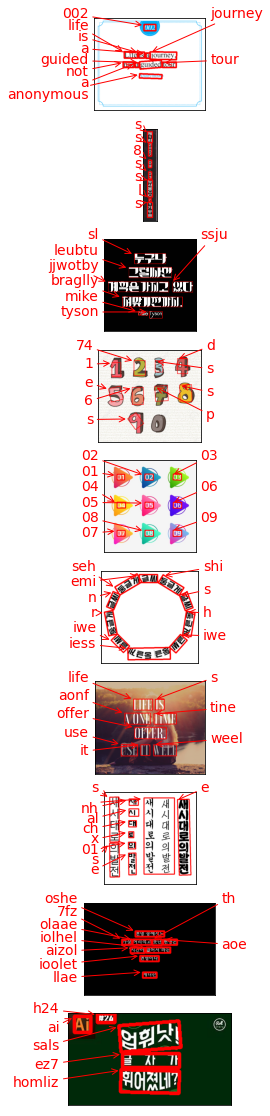

In [10]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- Tesseract OCR

In [11]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

# work_dir = os.getenv('HOME')+'/aiffel/ocr_python/testset'
# img_file_path = work_dir + '/index.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

# '/home/ssac2/aiffel/ocr_python/testset/1.png' [37:-4]
for file in file_list:
    globals()['cropped_image_path_list_{}'.format(file[38:-4])] = crop_word_regions(file, file[:-4])
    print('cropped_image_path_list_{}'.format(file[38:-4]))

/home/ssac2/aiffel/ocr_python/testset/1/0000.png
/home/ssac2/aiffel/ocr_python/testset/1/0001.png
/home/ssac2/aiffel/ocr_python/testset/1/0002.png
/home/ssac2/aiffel/ocr_python/testset/1/0003.png
/home/ssac2/aiffel/ocr_python/testset/1/0004.png
/home/ssac2/aiffel/ocr_python/testset/1/0005.png
/home/ssac2/aiffel/ocr_python/testset/1/0006.png
/home/ssac2/aiffel/ocr_python/testset/1/0007.png
/home/ssac2/aiffel/ocr_python/testset/1/0008.png
/home/ssac2/aiffel/ocr_python/testset/1/0009.png
/home/ssac2/aiffel/ocr_python/testset/1/0010.png
/home/ssac2/aiffel/ocr_python/testset/1/0011.png
cropped_image_path_list_1
/home/ssac2/aiffel/ocr_python/testset/4/0000.png
/home/ssac2/aiffel/ocr_python/testset/4/0001.png
/home/ssac2/aiffel/ocr_python/testset/4/0002.png
/home/ssac2/aiffel/ocr_python/testset/4/0003.png
/home/ssac2/aiffel/ocr_python/testset/4/0004.png
/home/ssac2/aiffel/ocr_python/testset/4/0005.png
/home/ssac2/aiffel/ocr_python/testset/4/0006.png
/home/ssac2/aiffel/ocr_python/testset/4/000

In [12]:
cropped_image_path_list_1

['/home/ssac2/aiffel/ocr_python/testset/1/0000.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0001.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0002.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0003.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0004.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0005.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0006.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0007.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0008.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0009.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0010.png',
 '/home/ssac2/aiffel/ocr_python/testset/1/0011.png']

In [26]:
def recognize_images_eng(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
    
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
print('/home/ssac2/aiffel/ocr_python/testset/1.png') # 이미지 출력으로 대체
recognize_images_eng(cropped_image_path_list_1)
print('\n/home/ssac2/aiffel/ocr_python/testset/2.jpg')
recognize_images_kor(cropped_image_path_list_2)
print('\n/home/ssac2/aiffel/ocr_python/testset/3.png')
recognize_images_eng(cropped_image_path_list_3)
print('\n/home/ssac2/aiffel/ocr_python/testset/4.png')
recognize_images_kor(cropped_image_path_list_4)
print('\n/home/ssac2/aiffel/ocr_python/testset/5.jpg')
recognize_images_kor(cropped_image_path_list_5)
print('\n/home/ssac2/aiffel/ocr_python/testset/6.png')
recognize_images_eng(cropped_image_path_list_6)
print('\n/home/ssac2/aiffel/ocr_python/testset/7.png')
recognize_images_kor(cropped_image_path_list_7)
print('\n/home/ssac2/aiffel/ocr_python/testset/8.png')
recognize_images_kor(cropped_image_path_list_8)
print('\n/home/ssac2/aiffel/ocr_python/testset/9.png')
recognize_images_kor(cropped_image_path_list_9)
print('\n/home/ssac2/aiffel/ocr_python/testset/10.png')
recognize_images_kor(cropped_image_path_list_10)

/home/ssac2/aiffel/ocr_python/testset/1.png
Life

iS

d

journey,

not

ad

culde

d tour.

——l

Anonymou

~


Done

/home/ssac2/aiffel/ocr_python/testset/2.jpg
번명 중에서도

가장 어리석고 못난 변명은

지간이

7 발기 큰분

내이 드리게

002

Done

/home/ssac2/aiffel/ocr_python/testset/3.png
‘3)

Done

/home/ssac2/aiffel/ocr_python/testset/4.png

6

2

쓰


그

등

!


Done

/home/ssac2/aiffel/ocr_python/testset/5.jpg

Done

/home/ssac2/aiffel/ocr_python/testset/6.png

Done

/home/ssac2/aiffel/ocr_python/testset/7.png
= 20

틀4 |) 나

| 07구대

고

『,

| 24 | 02411|

니오

21

Done

/home/ssac2/aiffel/ocr_python/testset/8.png
:


“


Done

/home/ssac2/aiffel/ocr_python/testset/9.png
/내

7

=

2

미

1

|

Done

/home/ssac2/aiffel/ocr_python/testset/10.png
1

개

그가

비시

Done


# Step3. 테스트 결과 정리

- 1st Image
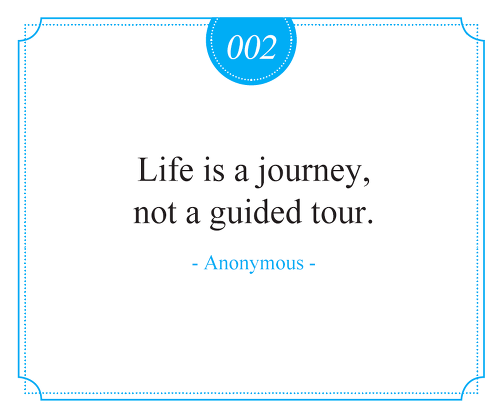

### 평범한 영어 문장의 경우 3개의 모델 모두 괜찮은 성능을 보임을 알 수 있었다.

| Keras-ocr  | Google OCR API  |Tesseract OCR|
|:---:|:---:|:---:|
|<img width=400>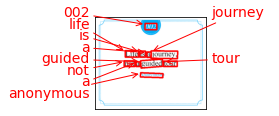|Texts:<br>"002<br>Life is a journey,<br>not a guided tour.<br>- Anonymous -<br>"<br>   |<br>Life<br>iS<br>d<br>journey,<br>not<br>ad<br>culde<br>d tour.<br>——l<br>Anonymou<br>~<br>|

- 2nd Image
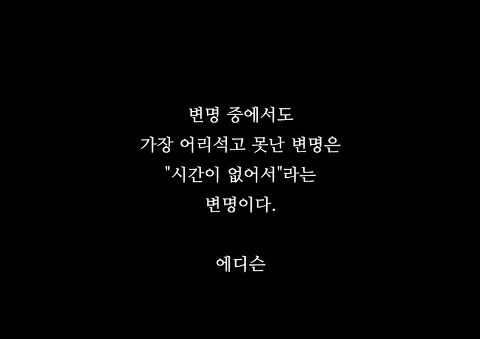 

### 한글 문장의 경우 Keras-ocr 모델은 지원하지 않는 것 같다. Tesseract OCR의 경우도 Detection은 잘 수행하지만, Recognition은 미흡한 것을 확인할 수 있다.

|Keras-ocr   |Google OCR API   |Tesseract OCR   |
|:---:|:---:|:---:|
|<img width=400>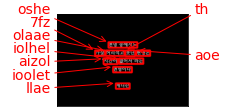   |<br>Texts:<br>"변명 중에서도<br>가장 어리석고 못난 변명은<br>"시간이 없어서"라는<br>변명이다.<br>에디슨<br>"|<br>번명 중에서도<br>가장 어리석고 못난 변명은<br>지간이<br>7 발기 큰분<br>내이 드리게<br>002|

- 3rd Image
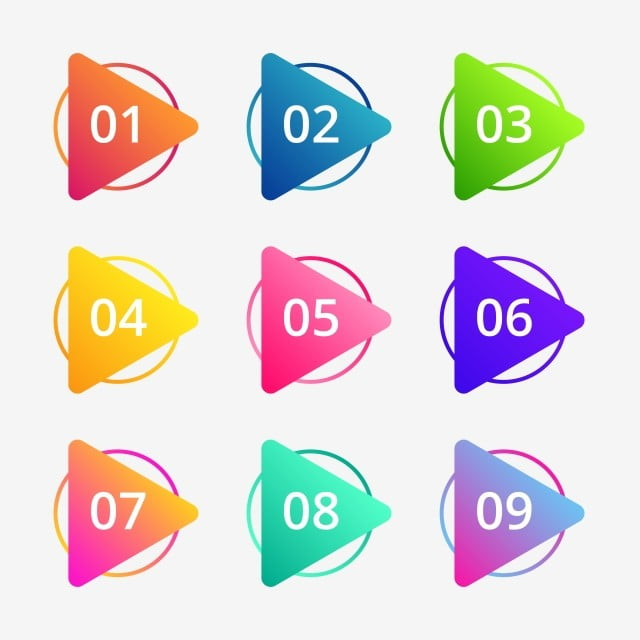

### 숫자의 경우 Keras-ocr, Google OCR API가 좋은 성능을 보였다. Tesseract OCR의 경우에는 이러한 변수가 있는 숫자 인식은 힘들어보인다.



|Keras-ocr  |Google OCR API   |Tesseract OCR   |
|:---:|:---:|:---:|
|<img width=400>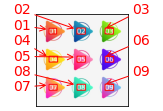   |<br>Texts:<br>"01 02 ( 03<br>04 05 ( 06<br>07 08 ( 09<br>"| 인식하지 못함  |

- 4th Image
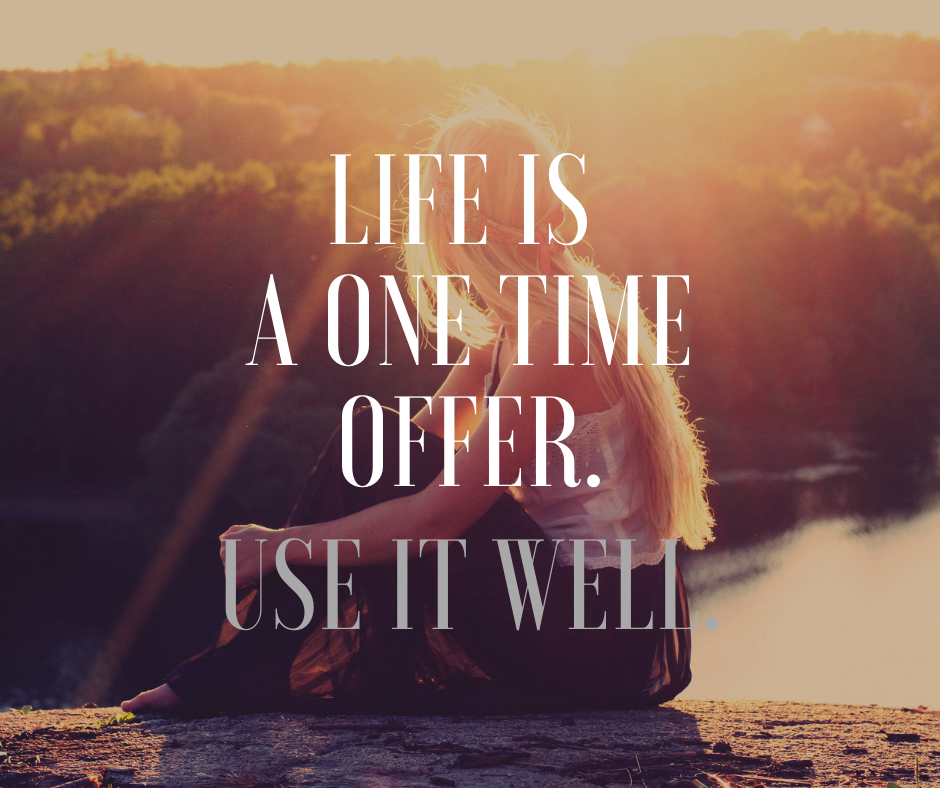

### 글자의 색상이 배경에 의해 잘 알아보기 힘든 경우에도 Keras-ocr과 Google OCR은 좋은 성능을 보였다.



|Keras-ocr   |Google OCR API   |Tesseract OCR   |
|:---:|:---:|:---:|
|<img width=400> 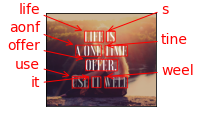 | <br>Texts:<br>"LIFE IS<br>A ONE TIME<br>OFFER.<br>USE IT WELF<br>"| 인식하지 못함  |

- 5th Image
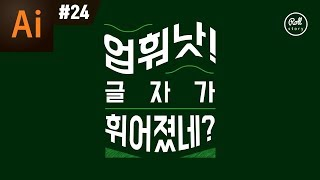

### 글자가 휘어져 있는 경우에는 Google OCR API와 Keras-ocr이 Detection은 잘 수행하는 것을 확인하였다. 다만, Keras-ocr의 경우 한글 Recognition에 한계가 보여 아쉽다.

|Keras-ocr   |Google OCR API   |Tesseract OCR   |
|:---:|:---:|:---:|
|<img width=400> 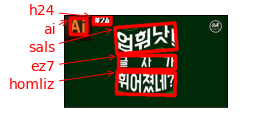 |<br>"#24<br>Ai<br>lary<br>글자 가<br>휘어졌네?<br>"|<br>1<br>개<br>그가<br>비시   |

# Step4. 결과 분석과 결론 제시

#### - 구현하고자 하는 서비스의 목적과 내용
    
    서비스 : 국내 차량 번호판 인식시스템
    내용 : 영상이나 사진에서 추출되는 정보를 바탕으로 차량의 번호판을 인식해 차량 번호를 출력해주는 시스템을 구현하고자 함.
    
    
    
#### - 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시
    
    국내 차량 번호판은 한글과 숫자로 구성되어 있다. 따라서, 한글과 숫자 영역에 대한 Detection과 Recognition이 잘 수행되어야 하는 모델이 사용되어야 한다. 또한, 특수 차량 번호판에 대해서도 인식할 수 있어야 하므로 노이즈가 있는 데이터에 대해서도 인식이 잘 이루어져야 한다고 생각한다.
    
    1) Google OCR API : 위에서 말한 조건에 가장 부합하는 모델이라고 생각한다. 한글, 영어 상관없이 Recognition이 잘 되는 모델이며, 텍스트 영역에 대한 Detection 역시 잘 수행되는 것을 확인하였다. 노이즈가 있는 데이터, 입체감을 보이는 텍스트에도 나름 괜찮은 성능을 보이고 있는 것을 확인하였다.
    
    2) Keras-ocr : 한글에 대한 Recognition만 잘 수행된다면 활용가치가 있는 모델이라고 생각한다. 텍스트 영역에 대한 Detection이 잘 수행되며, 노이즈가 있는 데이터에도 괜찮은 성능을 보여주고 있기 때문. 다만 입체적 형태의 글자에 대한 Recognition은 좀 더 보완할 여지가 있는 것 같다. (차량 번호판의 경우 그 정도가 심하지 않기 때문에 활용가능성은 보임)
    
    3) Tesseract OCR : 국내 차량 번호판 인식을 위한 모델로는 적합해보이지 않는다. 우선적으로 Recognition 성능이 좋지 않으며, 노이즈가 있는 데이터에서는 전혀 Detection을 하지 못하는 것을 확인하였다.
    
    
    
#### - 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정
    
    위의 기준에 따라 Google OCR API를 활용하는 것이 가장 좋은 선택으로 여겨진다.

# 회고

1) OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? (목표로 하는 서비스가 OCR 적용 가능하며, OCR을 활용했을 때 더욱 유용해지는가)

2) 모델 평가기준이 명확하고 체계적으로 세워졌는가? (평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었는가)

3) 평가 기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가? (최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었는가)